In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# !pip install evaluate
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification,AutoTokenizer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
df = pd.read_csv(os.path.join(dirname, 'train.csv'))

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [6]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
df['keyword'].value_counts()


fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

<AxesSubplot:xlabel='keyword'>

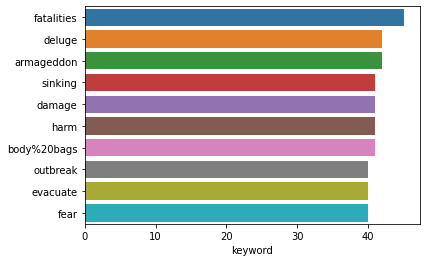

In [8]:
top10 = df['keyword'].value_counts()[:10]
sns.barplot(x=top10, y=top10.index)

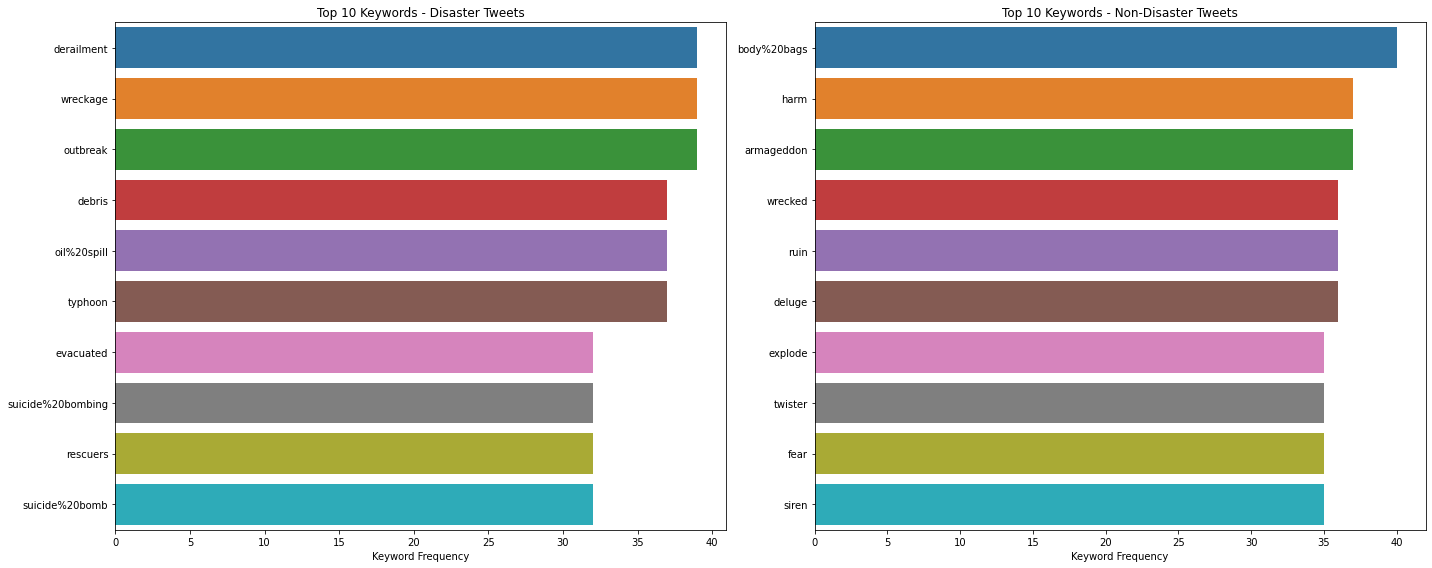

In [9]:
disaster=df.loc[df["target"] == 1]["keyword"].value_counts()[:10]
no_disaster= df.loc[df["target"] == 0]["keyword"].value_counts()[:10]
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=disaster, y=disaster.index, orient='h', ax=ax[0])
ax[0].set_title("Top 10 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(x=no_disaster, y=no_disaster.index, orient='h', ax=ax[1])
ax[1].set_title("Top 10 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

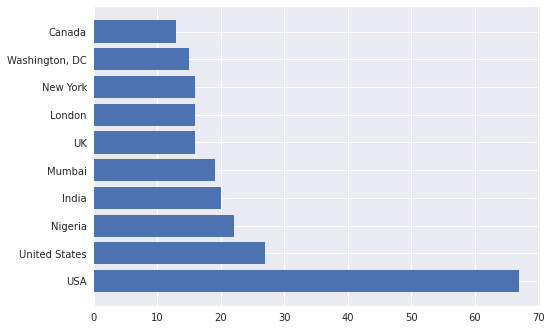

In [10]:
top10disasterlocs = df.loc[df['target']==1]['location'].value_counts()[:10]
plt.style.use('seaborn')
plt.barh(top10disasterlocs.index,top10disasterlocs,)
plt.show()

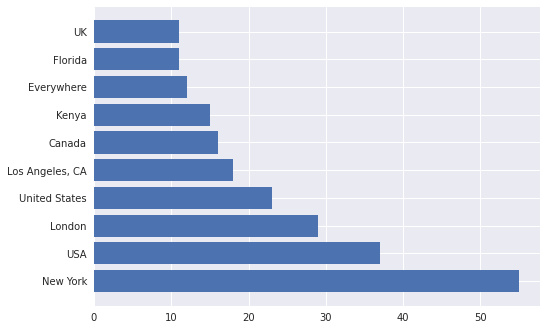

In [11]:
top10non_disasterlocs = df.loc[df['target']==0]['location'].value_counts()[:10]
plt.style.use('seaborn')
plt.barh(top10non_disasterlocs.index,top10non_disasterlocs,)
plt.show()

In [12]:
ds = Dataset.from_pandas(df.drop(columns=['id','location','keyword']))
ds

Dataset({
    features: ['text', 'target'],
    num_rows: 7613
})

In [13]:
model_nm = 'vinai/bertweet-base'
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
tokz.tokenize(df['text'][1])

['Forest', 'fire', 'near', 'La', 'Ron@@', 'ge', 'S@@', 'ask@@', '.', 'Canada']

In [15]:
def tok_func(x): return tokz(x["text"])

In [16]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

In [17]:
row=tok_ds[0]
row['target']

1

In [18]:
tok_ds = tok_ds.remove_columns(['text']).rename_columns({'target':'labels'}).with_format('torch')

In [19]:
dds = tok_ds.train_test_split(0.25)
dds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5709
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1904
    })
})

In [20]:
df_test = pd.read_csv(os.path.join(dirname, 'test.csv'))

In [32]:
eval_ds = Dataset.from_pandas(df_test.drop(columns=['id','keyword','location'])).map(tok_func, batched=True)


  0%|          | 0/4 [00:00<?, ?ba/s]

In [36]:
eval_ds.remove_columns(["text"])
eval_ds

Dataset({
    features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [22]:
from transformers import TrainingArguments,Trainer

In [23]:
bs = 128
epochs= 5
lr = 8e-5

args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [24]:
from datasets import load_metric

def compute_metric(eval_preds):
    metric = load_metric("f1")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [25]:
import torch
torch.cuda.empty_cache()

model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=2)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=compute_metric)

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [26]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5709
  Num Epochs = 5
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 225


Epoch,Training Loss,Validation Loss,F1
1,No log,0.393585,0.802606
2,No log,0.399354,0.802125
3,No log,0.542063,0.782964
4,No log,0.542969,0.792857
5,No log,0.582664,0.795210


***** Running Evaluation *****
  Num examples = 1904
  Batch size = 256


***** Running Evaluation *****
  Num examples = 1904
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1904
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1904
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1904
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=225, training_loss=0.2915857950846354, metrics={'train_runtime': 177.9454, 'train_samples_per_second': 160.414, 'train_steps_per_second': 1.264, 'total_flos': 812935049967840.0, 'train_loss': 0.2915857950846354, 'epoch': 5.0})

In [27]:
preds = trainer.predict(eval_ds)
preds

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3263
  Batch size = 256


PredictionOutput(predictions=array([[-1.926,  1.727],
       [-2.617,  2.547],
       [-2.604,  2.537],
       ...,
       [-2.602,  2.527],
       [-1.573,  1.566],
       [-2.553,  2.48 ]], dtype=float16), label_ids=None, metrics={'test_runtime': 5.6514, 'test_samples_per_second': 577.382, 'test_steps_per_second': 2.3})

In [56]:
labels=np.argmax(preds.predictions, axis=-1)
labels[50]

0

In [64]:
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
submission['target'] = labels
submission.head()
submission.to_csv('submission.csv', index=False)